# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [4]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [5]:
df = pd.read_csv('../../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
# df.head(5)

In [6]:
df = df.astype(int)
# df.head(5)

In [7]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df = df[df['DEP_DELAY'] > 0]

df = df.head(500)

### Transformation Testing

DEP_DELAY skew score
3.1754945061136244
DEP_DELAY_log skew score
0.2126196890937551
DEP_DELAY_BOXCOX skew score
0.027600699691935238


/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


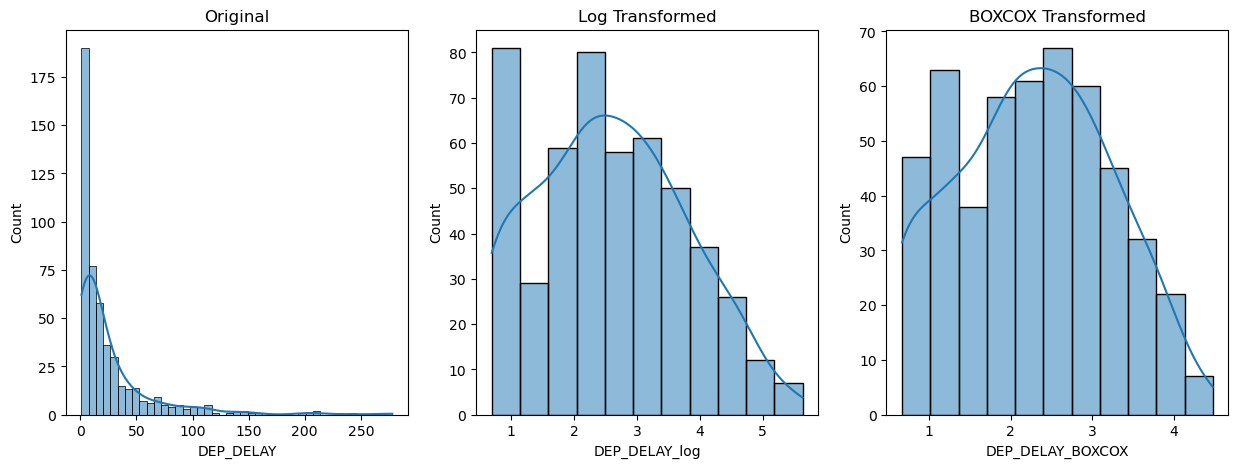

In [8]:
print('DEP_DELAY skew score')
print(df['DEP_DELAY'].skew())  # If > 0.5 or < -0.5, transformation is needed

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])  # log1p avoids log(0) issue
df['DEP_DELAY_sqrt'] = np.sqrt(df['DEP_DELAY_shifted']) # sqrt version

from scipy.stats import boxcox
df['DEP_DELAY_BOXCOX'], lambda_ = boxcox(df['DEP_DELAY_shifted'] + 1)  # Adding 1 to avoid issues with 0
# print(f' lambda value {lambda_}')

print('DEP_DELAY_log skew score')
print(df['DEP_DELAY_log'].skew())

print('DEP_DELAY_BOXCOX skew score')
print(df['DEP_DELAY_BOXCOX'].skew())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['DEP_DELAY'], kde=True, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(df['DEP_DELAY_log'], kde=True, ax=axes[1])
axes[1].set_title('Log Transformed')

sns.histplot(df['DEP_DELAY_BOXCOX'], kde=True, ax=axes[2])
axes[2].set_title('BOXCOX Transformed')

plt.show()

In [9]:
df['DEP_DELAY_BOXCOX']

2       3.183439
9       1.307555
14      3.867137
26      1.503966
30      1.793158
          ...   
2175    2.239480
2176    1.048763
2177    1.793158
2186    2.900946
2187    2.469441
Name: DEP_DELAY_BOXCOX, Length: 500, dtype: float64

In [10]:
X = df.drop(columns=['DEP_DELAY_log', 'DEP_DELAY','DEP_DELAY_shifted', 'DEP_DELAY_sqrt', 'DEP_DELAY_BOXCOX']) #Dropping Transformation comparsion testing columns

# Using BoxCox Transformation
y = df['DEP_DELAY_BOXCOX'] # Target variable

y.head(3)

2     3.183439
9     1.307555
14    3.867137
Name: DEP_DELAY_BOXCOX, dtype: float64

### Feature Selection (Post Boxcox Transformation)

In [11]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_25727/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [12]:
k_num_features = 10
num_remove_feature = 0

# Using 9 features only taking all F-Score above 60

In [13]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df_before = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df_before = feature_df_before.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df_before)

Selected Features:
                Feature    F-Score
1      CRS_ELAPSED_TIME  12.229970
2              DISTANCE  12.038811
4  OP_UNIQUE_CARRIER_DL   8.870390
9              DEST_SLC   7.646943
7              DEST_BWI   6.467945
8              DEST_LAS   6.448982
5  OP_UNIQUE_CARRIER_MQ   6.231128
6  OP_UNIQUE_CARRIER_YX   5.950140
3  OP_UNIQUE_CARRIER_B6   5.936279
0          DAY_OF_MONTH   5.195401


### BoxCox TransFormation

In [14]:
from scipy.stats import boxcox
X['sch_dep_boxcox'], lambda_ = boxcox(X['sch_dep'] + 1)  #Top1 Feature 
X['CRS_DEP_M_boxcox'], lambda_ = boxcox(X['CRS_DEP_M'] + 1) #Top2 Feature
X['OP_UNIQUE_CARRIER_DL_boxcox'], lambda_ = boxcox(X['OP_UNIQUE_CARRIER_DL'] + 1)  #Top3 Feature

X['CRS_ELAPSED_TIME_boxcox'], lambda_ = boxcox(X['CRS_ELAPSED_TIME'] + 1)  #Top4 Feature
X['DISTANCE_boxcox'], lambda_ = boxcox(X['DISTANCE'] + 1)  #Top5 Feature
X['OP_UNIQUE_CARRIER_B6_boxcox'], lambda_ = boxcox(X['OP_UNIQUE_CARRIER_B6'] + 1)  #Top6  Feature

X['OP_UNIQUE_CARRIER_MQ_boxcox'], lambda_ = boxcox(X['OP_UNIQUE_CARRIER_MQ'] + 1)  #Top7  Feature
X['Wind_Speed_boxcox'], lambda_ = boxcox(X['Wind Speed'] + 1) #Top8  Feature
X['Pressure_boxcox'], lambda_ = boxcox(X['Pressure'] + 1) #Top9  Feature



/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_25727/42130793.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['sch_dep_boxcox'], lambda_ = boxcox(X['sch_dep'] + 1)  #Top1 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_25727/42130793.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['CRS_DEP_M_boxcox'], lambda_ = boxcox(X['CRS_DEP_M'] + 1) #Top2 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_25727/42130793.py:4: PerformanceWarning: DataFrame is highly fragmented.  This

In [15]:
# Drop columns that are log transform
X = X.drop(columns=[
            # 'sch_dep',
            # 'CRS_DEP_M',
            # 'OP_UNIQUE_CARRIER_DL',  
            # 'CRS_ELAPSED_TIME', 
            # 'DISTANCE',  
            # 'OP_UNIQUE_CARRIER_B6', 
            # 'OP_UNIQUE_CARRIER_MQ', 
            # 'Wind Speed',  
            # 'Pressure',
])

X = X.drop(columns=[
            'sch_dep_boxcox',
            'CRS_DEP_M_boxcox',
            'OP_UNIQUE_CARRIER_DL_boxcox',  
            'CRS_ELAPSED_TIME_boxcox', 
            'DISTANCE_boxcox',  
            'OP_UNIQUE_CARRIER_B6_boxcox', 
            'OP_UNIQUE_CARRIER_MQ_boxcox', 
            'Wind_Speed_boxcox',  
            'Pressure_boxcox',
])

### Comparsing F-Score of Boxcox-Feature 
Check Feature Selection F-Score Again

In [16]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features - num_remove_feature # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features (New Comparsion):")
print(feature_df)

Selected Features (New Comparsion):
                Feature    F-Score
1      CRS_ELAPSED_TIME  12.229970
2              DISTANCE  12.038811
4  OP_UNIQUE_CARRIER_DL   8.870390
9              DEST_SLC   7.646943
7              DEST_BWI   6.467945
8              DEST_LAS   6.448982
5  OP_UNIQUE_CARRIER_MQ   6.231128
6  OP_UNIQUE_CARRIER_YX   5.950140
3  OP_UNIQUE_CARRIER_B6   5.936279
0          DAY_OF_MONTH   5.195401


### Split Training and Test Data 80:20

In [17]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 27)

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Diff Regression

In [19]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# from sklearn.tree import DecisionTreeRegressor
# regressor = DecisionTreeRegressor(random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.svm import SVR
# regressor = SVR(kernel = 'rbf')
# regressor.fit(X_train, y_train)

# from sklearn.linear_model import Ridge
# regressor = Ridge(alpha=0.5)  # You can adjust alpha (regularization strength)
# regressor.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestRegressor

# # Use Random Forest as an alternative
# regressor = RandomForestRegressor(
#     n_estimators=100, 
#     max_depth=10, 
#     random_state=42
# )
# regressor.fit(X_train, y_train)

### KNN Model

In [20]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=10, metric='manhattan', weights='distance')
# regressor = KNeighborsRegressor(n_neighbors=19, metric='euclidean')

regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [21]:
y_pred_boxcox = regressor.predict(X_test)

# Reverse Box-Cox Transformation
print(lambda_)

if lambda_ == 0:
    y_pred = np.exp(y_pred_boxcox)  # If λ = 0, use exp()
else:
    y_pred = (y_pred_boxcox * lambda_ + 1) ** (1 / lambda_)  # General inverse Box-Cox formula


104.28662018726499


In [22]:
y_pred

array([1.05783091, 1.04532397, 1.05745916, 1.05363211, 1.05293057,
       1.04963098, 1.05201716, 1.05111703, 1.05222086, 1.0536369 ,
       1.05254947, 1.0586432 , 1.05472321, 1.05019942, 1.05468077,
       1.05221663, 1.0529634 , 1.05378025, 1.05751463, 1.05658204,
       1.05369012, 1.05510735, 1.04902832, 1.05381594, 1.0549565 ,
       1.05423605, 1.05490738, 1.05209429, 1.0537897 , 1.05672859,
       1.05538557, 1.05534306, 1.056779  , 1.05776235, 1.05069166,
       1.05715721, 1.05618026, 1.05114351, 1.0562622 , 1.04994942,
       1.0528233 , 1.05291921, 1.05457675, 1.05026563, 1.05295831,
       1.05619359, 1.05454866, 1.0559514 , 1.05301227, 1.05361372,
       1.05087865, 1.04900955, 1.05170565, 1.05307546, 1.05538131,
       1.05164509, 1.05288144, 1.05428935, 1.05307985, 1.04978949,
       1.05440615, 1.05362523, 1.05599673, 1.05013967, 1.05439803,
       1.0527154 , 1.0507961 , 1.05450034, 1.05689339, 1.05365464,
       1.05422873, 1.05797978, 1.05087696, 1.04174863, 1.04998

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print("\nModel Performance Metrics:")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"R-Squared (R2): {r2:.4f}")

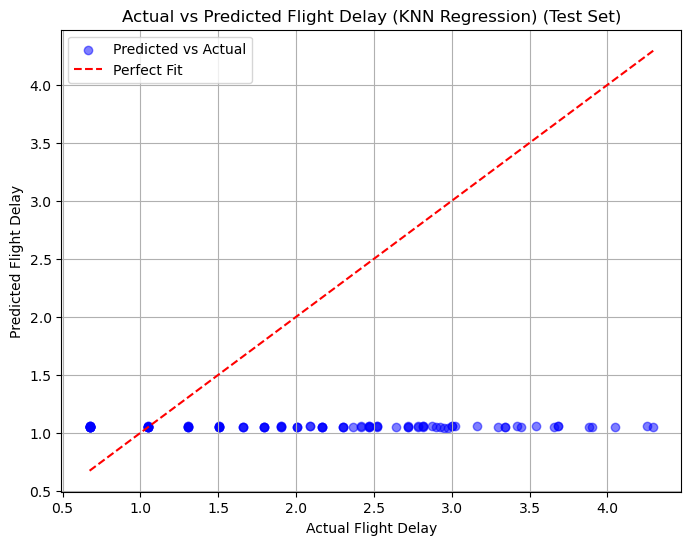

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression) (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 100, 2)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best k:", grid.best_params_)

Best k: {'n_neighbors': 83}


In [26]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation scores:", -cv_scores)

Cross-validation scores: [0.9696548  1.30773245 1.02372606 1.06812612 1.14157949]


### What I have tested 

Test that yield the same result
- Model Selection (tried differenment models)
- Feature Engineering
- Reducing Model Complexity
- KNN Hyperparms tested 